In [100]:
NOTEBOOK_NAME = "e008_check_my_ipynb"

In [101]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [102]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [103]:
# train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [104]:
train = pd.read_pickle(
    f"../saved_data/e008_make_train/e008_make_train_merged_train.pkl"
)

test = pd.read_pickle(f"../saved_data/e008_make_train/e008_make_train_merged_test.pkl")

In [105]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [106]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [107]:
# # ひとつ前のlogのyad_idの値を取得
# train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
# test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

# 正解のyadoと1つ前のyadoの情報の追加

In [108]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# train = pd.merge(
#     train,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

In [109]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# test = pd.merge(
#     test,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

# データ型の変更

In [110]:
# categorical_colの定義
base_categorical_cols = [
    # "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "lrg_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
# previous_1_yado_categorical_cols = [
#     f"previous_1_{col}" for col in base_categorical_cols
# ]

# categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols
categorical_cols = now_yado_categorical_cols

In [111]:
# categorical_cols.remove("now_yad_no")
# categorical_cols.remove("previous_1_yad_no")

# # leak的な何かしらが起きているので、今は使わない
# # TODO: 予測するyad_noは重要な情報だと思うため入れ方を考える

In [112]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [113]:
train

,session_id,yad_no,reserve,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd
0,000007603d533d30453cc45d0f3d119f,58,0,58,0,26.0,NaN,1,NaN,NaN,NaN,NaN,e9316013ee1b03f4525fe361c46ce9c5,66c4d01ad8e30155582cf80b1d655986,1476be8d946a74a280b6b980fd17c6a7,26134995fa60df292b228fb068adc325
1,000007603d533d30453cc45d0f3d119f,103,0,103,0,NaN,NaN,0,NaN,NaN,NaN,NaN,e9316013ee1b03f4525fe361c46ce9c5,c71d257a01a8092eddf53c9f67705866,13798c9f89492b9f199e0f1a52e2f912,aaa3b1bb251c43c67a1bb7061afa9c22
2,000007603d533d30453cc45d0f3d119f,579,0,579,0,15.0,1.0,1,NaN,NaN,NaN,NaN,f0112abf369fb03cdc5f5309300913da,bd054cc265d68a400ccb976ac69c6463,5b1499dd1a709e37096d7d65d1208f66,572047925810f3e34b4e028512809c88
3,000007603d533d30453cc45d0f3d119f,2110,0,2110,0,NaN,1.0,0,NaN,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,fec19ba0016c012f3a06360cfff6da32,9cb0bdd21ca9dbfe240a8878fba58c40,6fb3715b1607e0b40ae04e7fd193f674
4,000007603d533d30453cc45d0f3d119f,2395,0,2395,0,113.0,1.0,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484752,fffffa7baf370083ebcdd98f26a7e31a,4121,0,4121,0,14.0,1.0,1,NaN,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,c86352f5b57e80fe545cfec1fd8505a1,f7fc8c414fb2528ecffe882510e33dda,05ad22285893e47bb828cf9b481168db
3484753,fffffa7baf370083ebcdd98f26a7e31a,10074,0,10074,0,9.0,1.0,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,a83f1272a366ddf7ae1dd11e62ea94f1,9d99b83fd36a1d98326bc10b00c9aaa2,906aafbba6a90af21aa8c8079bb65b78
3484754,fffffa7baf370083ebcdd98f26a7e31a,10715,0,10715,0,17.0,1.0,1,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,c86352f5b57e80fe545cfec1fd8505a1,2e35ef11a402c4687ced0fde49e628ea,1e011cd809001193eb57ad8fcec3b67d
3484755,fffffa7baf370083ebcdd98f26a7e31a,11822,0,11822,0,161.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c


In [114]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

# skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# for fold, (_, v_idx) in enumerate(
#     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# ):
#     train.loc[v_idx, "fold"] = fold

sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
for fold, (_, v_idx) in enumerate(
    sgkf.split(
        X=train,
        y=train["reserve"],
        groups=train["session_id"],
    )
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [115]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.917148
      1          0.082852
1     0          0.917162
      1          0.082838
2     0          0.917158
      1          0.082842
3     0          0.917160
      1          0.082840
4     0          0.917142
      1          0.082858
Name: proportion, dtype: float64

# LightGBM

In [116]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

# numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col
numeric_cols = now_yado_numeric_col

In [117]:
use_col = numeric_cols + categorical_cols
len(use_col)

9

In [118]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": -1,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.3,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [119]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します.
    "objective": "binary",
    # 木の最大数
    "n_estimators": 10000,
    # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    # 今回設定している 0.3 は比較的大きめの設定です
    "learning_rate": 0.3,
    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain",
    "random_state": 510,
}

In [120]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [121]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=3000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0


/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 230959, number of negative: 2556903
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 2787862, number of used features: 9
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082844 -> initscore=-2.404312
[LightGBM] [Info] Start training from score -2.404312
Training until validation scores don'

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 230958, number of negative: 2556777
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 2787735, number of used features: 9
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082848 -> initscore=-2.404267
[LightGBM] [Info] Start training from score -2.404267
Training until validation scores don'

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 230958, number of negative: 2556807
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 2787765, number of used features: 9
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082847 -> initscore=-2.404279
[LightGBM] [Info] Start training from score -2.404279
Training until validation scores don'

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 230958, number of negative: 2556796
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 2787754, number of used features: 9
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082847 -> initscore=-2.404274
[LightGBM] [Info] Start training from score -2.404274
Training until validation scores don'

/Users/shinichiro.saito/atmacup16/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 230959, number of negative: 2556953
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 2787912, number of used features: 9
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082843 -> initscore=-2.404331
[LightGBM] [Info] Start training from score -2.404331
Training until validation scores don'

In [122]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.7718404491107108

In [123]:
# TODO: fold0のみだとスコアが小さく出てしまう問題を解決する
# map@10を計算
def create_top_10_yad_predict(oof: pd.DataFrame, train: pd.DataFrame) -> pd.DataFrame:
    # 計算を行なった行に限定する
    train = train[oof != 0]
    oof = oof[oof != 0]

    _df = pd.concat(
        [train[["session_id", "yad_no"]], pd.Series(oof, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    out_df = out_df.fillna("0").astype(int)

    return out_df


oof_label_df = create_top_10_yad_predict(oof=oof, train=train)

oof_label_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,579,5849,103,10899,2395,11466,10436,7189,2110,58
0000ca043ed437a1472c9d1d154eb49b,10020,8107,8253,1748,846,2592,13535,4910,7341,13711
0000d4835cf113316fe447e2f80ba1c8,5713,1933,6489,4625,8855,12373,8937,12692,3319,1899
0000fcda1ae1b2f431e55a7075d1f500,12029,1652,5716,11272,8475,10451,8843,970,536,466
000104bdffaaad1a1e0a9ebacf585f33,12524,13463,898,2540,96,8051,12154,7405,13233,1668
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,8140,2259,709,2626,403,5316,13551,11342,7802,8179
ffff2360540745117193ecadcdc06538,12240,13466,2121,6447,638,963,9919,3012,13043,8586
ffff7fb4617164b2604aaf51c40bf82d,13719,7183,2282,9938,3291,11316,2892,3676,2238,1434


In [124]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [125]:
# いま作成した session_id と同じ並びで train_label を並び替え
sorted_train_label = (
    train_label.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [126]:
# MAPK (k=10) として計算
oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_label_df.values.tolist(),
    k=10,
)
oof_mapk_score

0.4653053894289624

<Axes: >

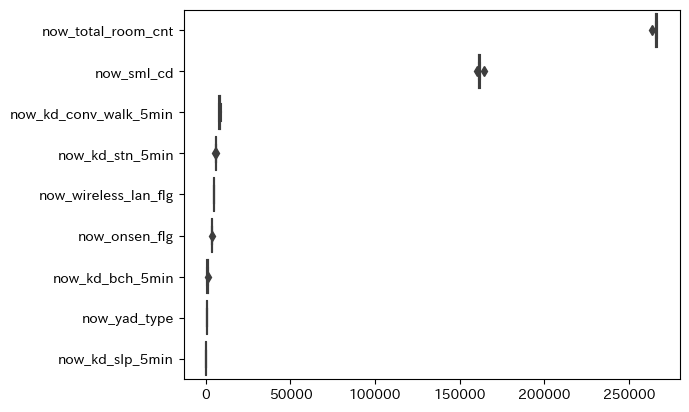

In [127]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [128]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

# Testに対する推論

In [129]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

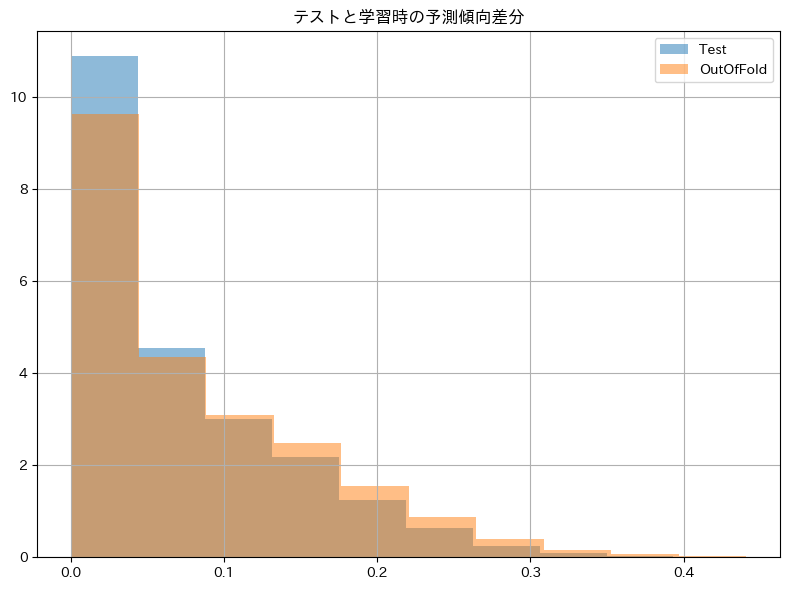

In [130]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [142]:
test["pred"] = pred

In [144]:
# TOP10に並び替え
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [145]:
pred_yad_df.isnull().sum()

predict_0    0
predict_1    0
predict_2    0
predict_3    0
predict_4    0
predict_5    0
predict_6    0
predict_7    0
predict_8    0
predict_9    0
dtype: int64

In [146]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4523,3560,11025,4844,822,3740,8050,6461,1272,11967
1,13682,11705,7502,713,3866,1210,10016,2029,13598,5279
2,11192,757,13265,5495,8304,4822,6694,6691,5559,12567
3,12320,12341,5999,9270,8186,1276,12439,12813,3305,8592
4,11512,6100,7787,13125,10817,11067,8205,2691,4510,8280
...,...,...,...,...,...,...,...,...,...,...
174695,6086,1997,11888,8496,241,545,1421,9630,12169,8532
174696,2270,445,4511,347,2035,9410,11471,9376,1721,2917
174697,3781,2396,4146,4096,12294,914,2271,2280,12510,12630
174698,2074,132,2365,7165,8556,3558,6376,5569,642,9784


In [150]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [151]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)